## LDA Approximation in the ZZ XZ case

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import curve_fit

# def pade(z:np.ndarray,a_p,b_p,c_p,d_p,e_p,a_q,b_q,c_q,d_q):
#     z_poly=z[None,:]**((4-np.arange(5)))[:,None]
#     f=(z_poly[0,:]*a_p+z_poly[1,:]*b_p+z_poly[2,:]*c_p+z_poly[3,:]*d_p+z_poly[-1,:]*e_p)/(z_poly[0,:]*a_q+z_poly[1,:]*b_q+z_poly[2,:]*c_q+z_poly[3,:]*d_q)
#     return f

def pade(m:np.ndarray,*params):
    z=m[:,0]
    x=m[:,1]    
    
    z_poly=(z[None,:])**((np.arange(0,5,1)))[:,None]
    x_poly=(x[None,:])**((np.arange(0,5,1)))[:,None]
    up=np.zeros(m.shape[0])
    for i in range(5):
        for j in range(5):
            up=up+params[5*i+j]*z_poly[i,:]*x_poly[j,:]
    down=np.ones(m.shape[0])
    for i in range(4):
        for j in range(4):
            down=down+params[25+4*i+j]*z_poly[i,:]*x_poly[j,:]
            
    
    f=up/down
    return f

def lda_functional(m:np.ndarray,params):
    f_lda=np.zeros_like(m[:,0,:])
    for a in range(m.shape[-1]):
        z=m[:,0,a]
        x=m[:,1,a]    
        
        z_poly=(z[None,:])**((np.arange(0,5,1)))[:,None]
        x_poly=(x[None,:])**((np.arange(0,5,1)))[:,None]
        up=np.zeros(m.shape[0])
        for i in range(5):
            for j in range(5):
                up=up+params[5*i+j]*z_poly[i,:]*x_poly[j,:]
        down=np.ones(m.shape[0])
        for i in range(4):
            for j in range(4):
                down=down+params[25+4*i+j]*z_poly[i,:]*x_poly[j,:]
        f_lda[:,a]=up/down
    return f_lda

#### Data

0.5050505050505051 0.5050505050505051



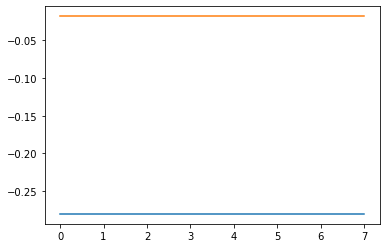

In [3]:

data=np.load('data/kohm_sham_approach/uniform/dataset_lda_h_0_5_omega_0_5_j_1_1nn_linear_span_100.npz')

z=data['density']
x=data['transverse_magnetization']

z_torch=torch.from_numpy(z)
x_torch=torch.from_numpy(x)



f_dens=data['density_F']
omega_value=data['omega_value']
h_value=data['h_value']

m_torch=torch.cat((z_torch.unsqueeze(1),x_torch.unsqueeze(1)),dim=1)
h_torch=torch.zeros_like(m_torch)
for i in range(100):
    for j in range(100):
        h_torch[i*100+j,0]=h_value[j]
        h_torch[i*100+j,1]=omega_value[i]

f=np.average(f_dens,axis=-1)
# # plt.hist(np.average(x,axis=-1),bins=100)
# # plt.show()
# # plt.hist(np.average(z,axis=-1),bins=100)
# # plt.show()
# # plt.hist(f,bins=100)
# # plt.show()
idx=10
jdx=10
print(omega_value[idx],h_value[jdx])

plt.plot(x[idx*100+jdx])
plt.plot(z[idx*100+jdx])
print()
plt.show()



(10000,)
(10000, 8)


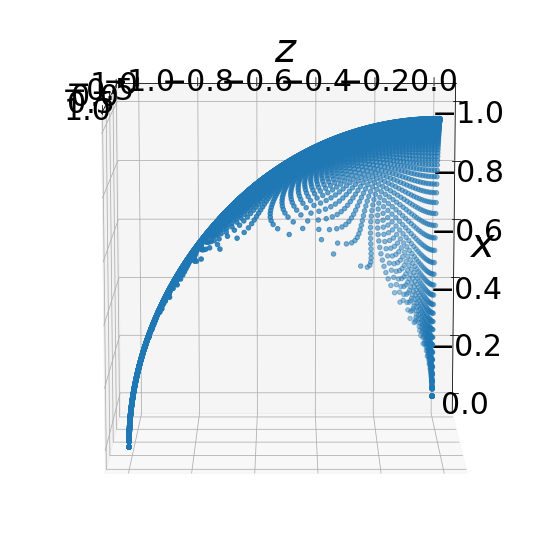

In [4]:
print(f.shape)
print(z.shape)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,10))
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),f,marker='o')
plt.ylabel(r'$z$',fontsize=40)
plt.xlabel(r'$x$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
ax.view_init(elev=100, azim=0)
plt.show()

#### Fit the LDA in case of costant fields

In [6]:
from src.tddft_methods.model_lda import modelLDA
import torch

m=np.append(z.reshape(-1,1,8),x.reshape(-1,1,8),axis=1)


params,_=curve_fit(f=pade,xdata=np.average(m,axis=-1),ydata=f,p0=0.5*np.ones(25+16))


#model=modelLDA(torch.tensor(coeff))
f_ml=lda_functional(m=m_test,params=params)
print(f_ml.shape)

(100, 8)


(100, 100)
(10000, 8)


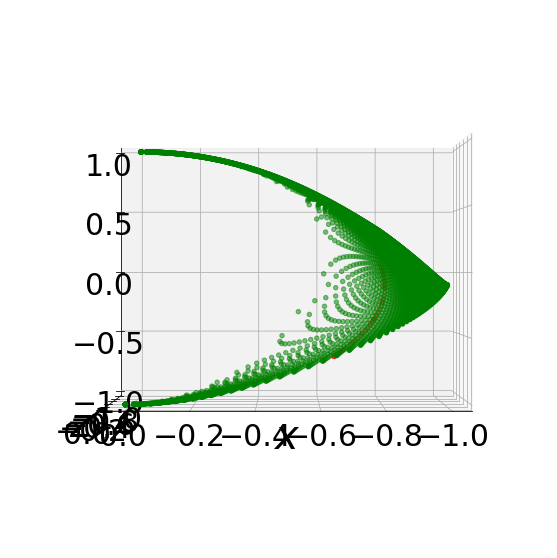

In [7]:
f_value_ml=np.average(f_ml,axis=-1)
f=f.reshape(100,100)
print(f.shape)
print(z.shape)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,10))
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),f,marker='o',color='green',alpha=0.5)
ax.scatter(x_value_test,z_value_test,f_value_ml,marker='o',color='red',alpha=0.2)
#ax.scatter(x_value_test,z_value_test,f_value_test,marker='o',color='red',alpha=0.2)
plt.ylabel(r'$z$',fontsize=40)
plt.xlabel(r'$x$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
ax.view_init(elev=0, azim=90)
ax.set_zlim([-1,1])
plt.show()


Omega spectrum and the comparison with the DL-functional derivative

(100, 100)
(10000, 8)
(10000,)
[0.         0.05050505 0.1010101  0.15151515 0.2020202  0.25252525
 0.3030303  0.35353535 0.4040404  0.45454545]


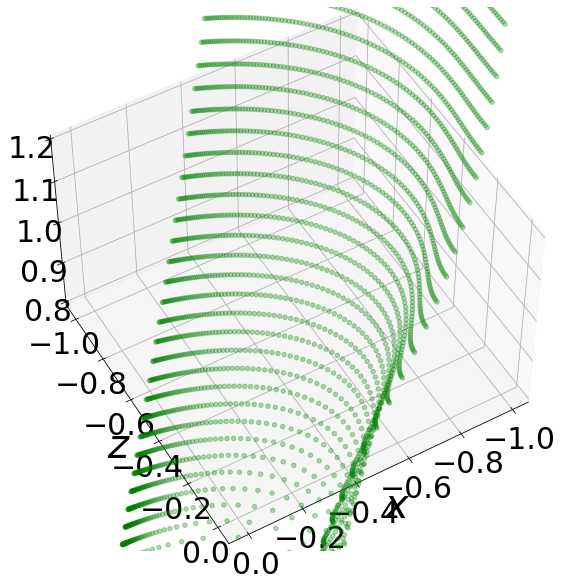

In [8]:
f_value_ml=np.average(f_ml,axis=-1)
f=f.reshape(100,100)
print(f.shape)
print(z.shape)
omegas=np.zeros_like(f.reshape(-1))
print(omegas.shape)
print(omega_value[:10])
for i in range(100):
    omegas[(i)*100:(i+1)*100]=omega_value[i]
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,10))
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),omegas,marker='o',color='green',alpha=0.3)
#ax.scatter(x_value_test,z_value_test,f_value_ml,marker='o',color='red',alpha=0.2)
#ax.scatter(x_value_test,z_value_test,f_value_test,marker='o',color='red',alpha=0.2)
plt.ylabel(r'$z$',fontsize=40)
plt.xlabel(r'$x$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
ax.view_init(elev=50, azim=60)
ax.set_zlim([1-0.2,1+0.2])
plt.show()

h spectrum

Save the LDA functional as pytorch model

In [9]:
model=modelLDA(coeff=params)


f_lda=model(m_torch).detach().numpy()

torch.save(model,'model_rep/lda/lda_model')

### Comparison LDA vs other models

Imports

In [10]:
from src.tddft_methods.kohm_sham_utils import (
    compute_the_gradient_of_the_functional,
)


With the Uniform dataset that we used in the TDDFT

In [35]:
model_disorder=torch.load('model_rep/kohm_sham/disorder/model_zzxz_2_input_channel_dataset_h_mixed_0.0_5.0_h_0.0-2.0_j_1_1nn_n_500k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock', map_location='cpu')
model_disorder.eval()

f_dl=model_disorder(m_torch).detach().numpy()

f_value_dl=np.average(f_dl,axis=-1)


omega_dl=compute_the_gradient_of_the_functional(m=m_torch,model=model_disorder,respect_to='x')
print(omega_dl[0:2])

h_dl=compute_the_gradient_of_the_functional(m=m_torch,model=model_disorder,respect_to='z')
print(omega_dl[0:2])


tensor([[ -9319.6252,  -9084.7237, -10268.2692,  -9295.2240, -11002.0256,
          -8435.4330,  -9721.4471,  -7427.5429],
        [-18155.0427, -17971.3547, -18110.9592, -17684.2809, -17803.8171,
         -17426.0976, -18154.9063, -17599.1450]], dtype=torch.float64)
torch.Size([10000, 2, 8])
tensor([[ -9319.6252,  -9084.7237, -10268.2692,  -9295.2240, -11002.0256,
          -8435.4330,  -9721.4471,  -7427.5429],
        [-18155.0427, -17971.3547, -18110.9592, -17684.2809, -17803.8171,
         -17426.0976, -18154.9063, -17599.1450]], dtype=torch.float64)


Comparison between the exact landscape of the field functional and the DL functional derivative ($\Omega$)

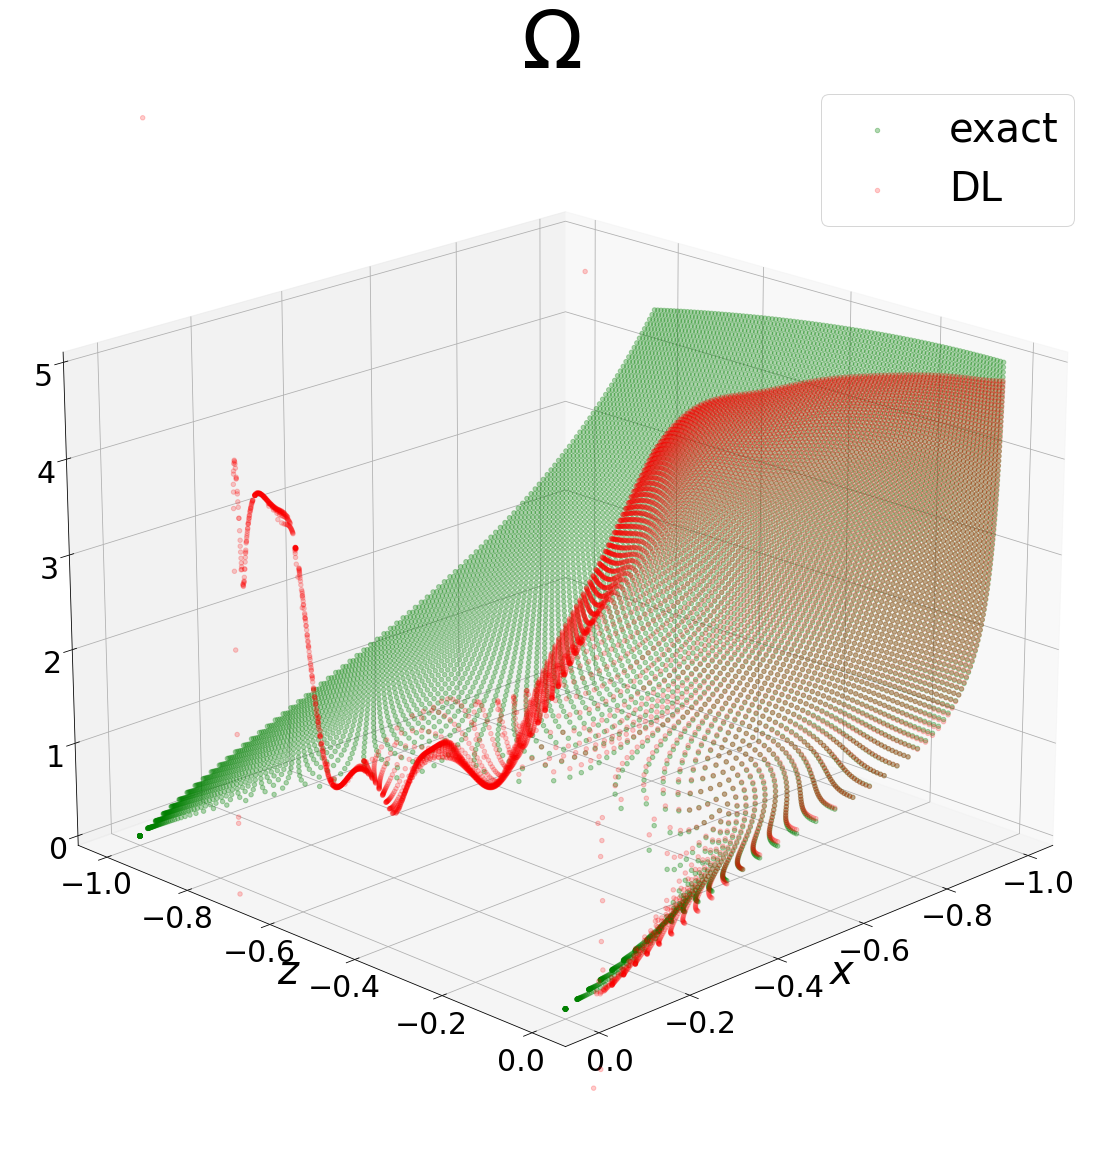

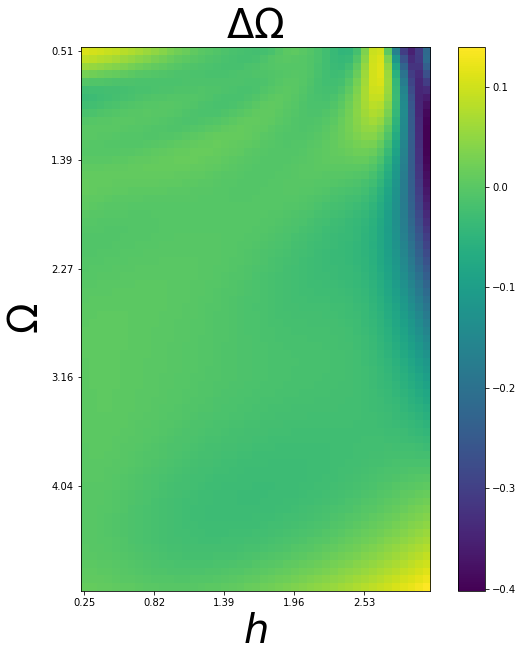

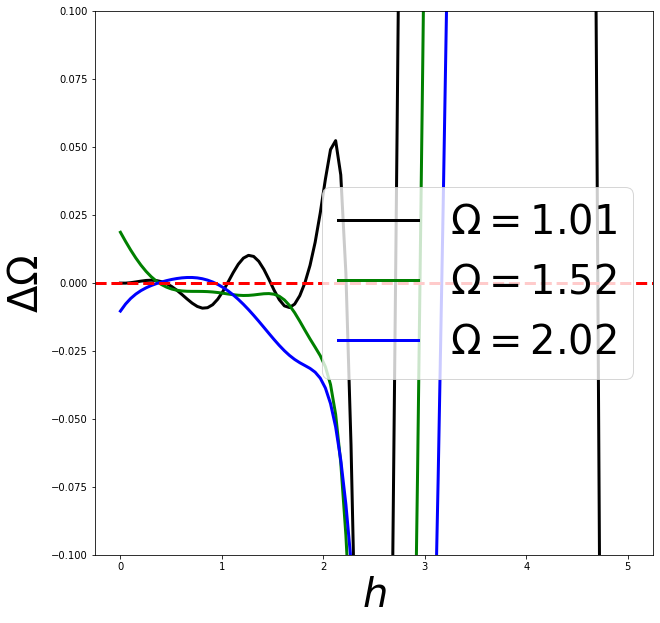

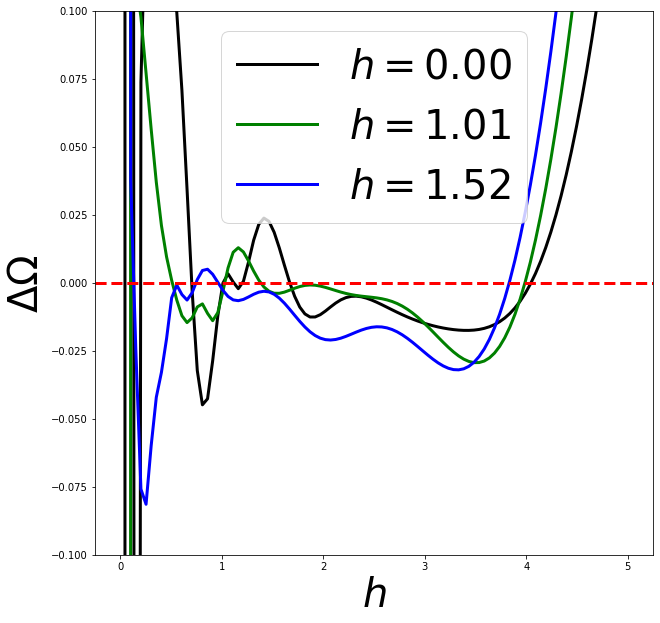

In [36]:
omegas=np.zeros_like(f.reshape(-1))
for i in range(100):
    omegas[(i)*100:(i+1)*100]=omega_value[i]
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(20,20))
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),omegas,marker='o',color='green',alpha=0.3,label='exact')
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),-1*omega_dl.mean(-1).detach().numpy(),marker='o',color='red',alpha=0.2,label='DL')
#ax.scatter(x_value_test,z_value_test,f_value_test,marker='o',color='red',alpha=0.2)
plt.title(r'$\Omega$',fontsize=80)
plt.ylabel(r'$z$',fontsize=40)
plt.xlabel(r'$x$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
plt.legend(fontsize=40)
ax.view_init(elev=20, azim=45)
ax.set_zlim([0,5])
plt.show()

delta_h=omegas+omega_dl.mean(-1).detach().numpy()
delta_h=delta_h.reshape(100,100)

plt.figure(figsize=(10,10))
init_h=5
final_h=50
init_omega=10
final_omega=80
plt.imshow(delta_h[init_omega:final_omega,init_h:final_h])
x_ticks=np.linspace(h_value[init_h],h_value[final_h],5)
y_ticks=np.linspace(omega_value[init_omega],omega_value[final_omega],5)
plt.xticks(np.arange(0,final_h-init_h,(final_h-init_h)//5),[f'{x_text:.2f}' for x_text in x_ticks])
plt.yticks(np.arange(0,final_omega-init_omega,(final_omega-init_omega)//5),[f'{x_text:.2f}' for x_text in y_ticks])
plt.ylabel(r'$\Omega$',fontsize=40)
plt.xlabel(r'$h$',fontsize=40)
plt.title(r'$\Delta \Omega$',fontsize=40)
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(h_value,delta_h[20,:],color='black',linewidth=3,label=r'$\Omega=$'+f'{omega_value[20]:.2f}')
plt.plot(h_value,delta_h[30,:],color='green',linewidth=3,label=r'$\Omega=$'+f'{omega_value[30]:.2f}')
plt.plot(h_value,delta_h[40,:],color='blue',linewidth=3,label=r'$\Omega=$'+f'{omega_value[40]:.2f}')
plt.axhline(y=0.,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\Delta \Omega$ ',fontsize=40)
plt.legend(fontsize=40)
plt.ylim([-0.1,0.1])
plt.show()

plt.figure(figsize=(10,10))
plt.plot(omega_value,delta_h[:,0],color='black',linewidth=3,label=r'$h=$'+f'{h_value[0]:.2f}')
plt.plot(omega_value,delta_h[:,20],color='green',linewidth=3,label=r'$h=$'+f'{h_value[20]:.2f}')
plt.plot(omega_value,delta_h[:,30],color='blue',linewidth=3,label=r'$h=$'+f'{h_value[30]:.2f}')
plt.axhline(y=0.,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\Delta \Omega$ ',fontsize=40)
plt.legend(fontsize=40)
plt.ylim([-0.1,0.1])
plt.show()

Comparison between the exact landscape of the field functional and the DL functional derivative ($h$)

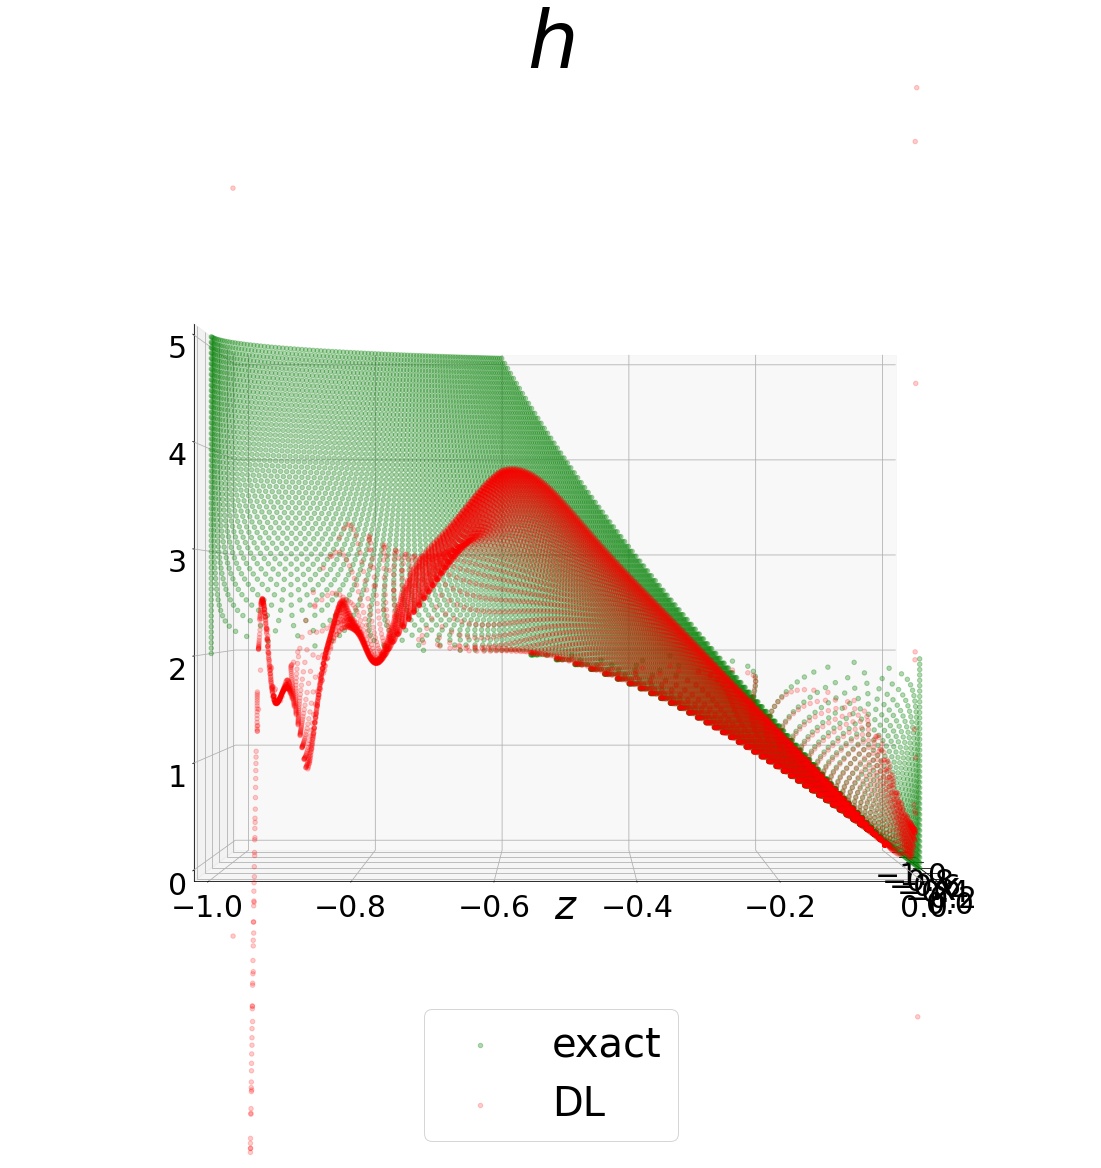

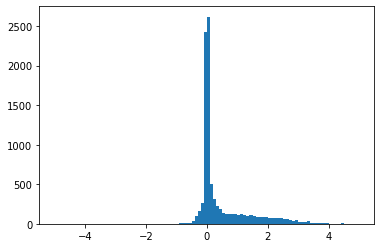

In [37]:
hs=np.zeros_like(f.reshape(-1))
for j in range(100):
    for i in range(100):
        hs[i+j*100]=h_value[i]
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(20,20))
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),hs,marker='o',color='green',alpha=0.3,label='exact')
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),-1*h_dl.mean(-1).detach().numpy(),marker='o',color='red',alpha=0.2,label='DL')
#ax.scatter(x_value_test,z_value_test,f_value_test,marker='o',color='red',alpha=0.2)
plt.title(r'$h$',fontsize=80)
plt.ylabel(r'$z$',fontsize=40)
plt.xlabel(r'$x$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
plt.legend(fontsize=40)
ax.view_init(elev=0, azim=0)
ax.set_zlim([0,5])
ax.set_ylim([-1,0])
#ax.set_xlim([-0.9001,-0.9])
plt.show()

plt.hist(hs+h_dl.mean(-1).detach().numpy(),bins=100,range=(-5,5))
plt.show()

Difference estimation

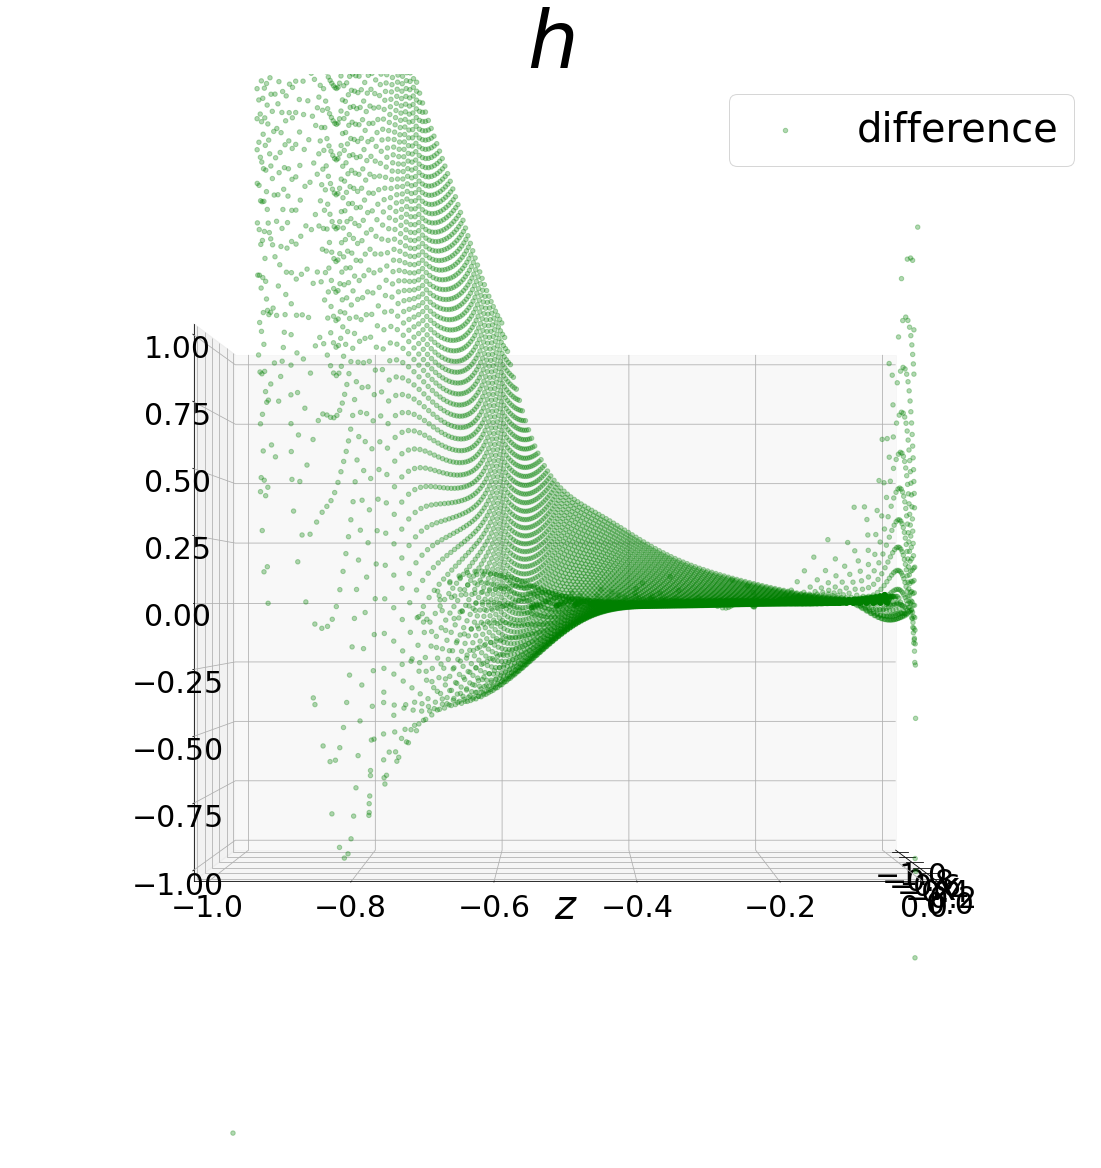

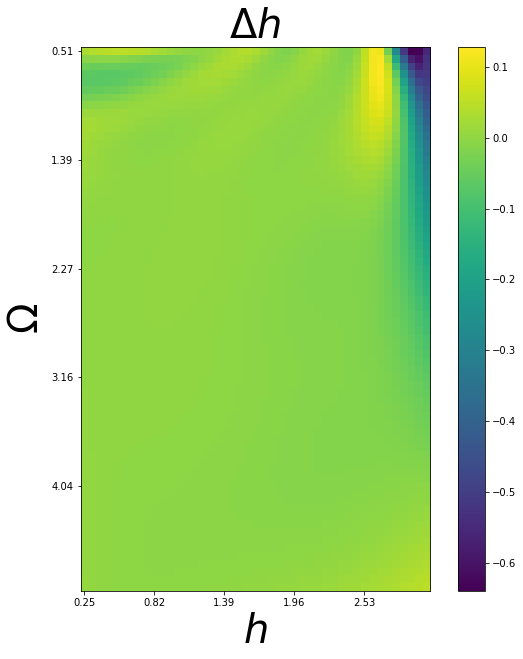

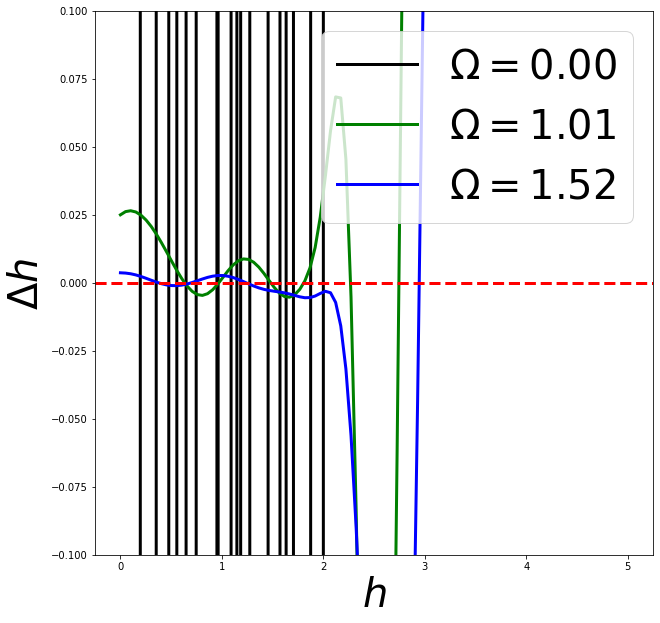

In [38]:
hs=np.zeros_like(f.reshape(-1))
for j in range(100):
    for i in range(100):
        hs[i+j*100]=h_value[i]
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(20,20))
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),hs+h_dl.mean(-1).detach().numpy(),marker='o',color='green',alpha=0.3,label='difference')
plt.title(r'$h$',fontsize=80)
plt.ylabel(r'$z$',fontsize=40)
plt.xlabel(r'$x$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
plt.legend(fontsize=40)
ax.view_init(elev=0, azim=0)
ax.set_zlim([-1,1])
ax.set_ylim([-1,0])
#ax.set_xlim([-0.9001,-0.9])
plt.show()

delta_h=hs+h_dl.mean(-1).detach().numpy()
delta_h=delta_h.reshape(100,100)

plt.figure(figsize=(10,10))
init_h=5
final_h=50
init_omega=10
final_omega=80
plt.imshow(delta_h[init_omega:final_omega,init_h:final_h])
x_ticks=np.linspace(h_value[init_h],h_value[final_h],5)
y_ticks=np.linspace(omega_value[init_omega],omega_value[final_omega],5)
plt.xticks(np.arange(0,final_h-init_h,(final_h-init_h)//5),[f'{x_text:.2f}' for x_text in x_ticks])
plt.yticks(np.arange(0,final_omega-init_omega,(final_omega-init_omega)//5),[f'{x_text:.2f}' for x_text in y_ticks])
plt.ylabel(r'$\Omega$',fontsize=40)
plt.xlabel(r'$h$',fontsize=40)
plt.title(r'$\Delta h$',fontsize=40)
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(h_value,delta_h[0,:],color='black',linewidth=3,label=r'$\Omega=$'+f'{omega_value[0]:.2f}')
plt.plot(h_value,delta_h[20,:],color='green',linewidth=3,label=r'$\Omega=$'+f'{omega_value[20]:.2f}')
plt.plot(h_value,delta_h[30,:],color='blue',linewidth=3,label=r'$\Omega=$'+f'{omega_value[30]:.2f}')
plt.axhline(y=0.,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\Delta h$ ',fontsize=40)
plt.legend(fontsize=40)
plt.ylim([-0.1,0.1])
plt.show()

Comparison in a direct plot

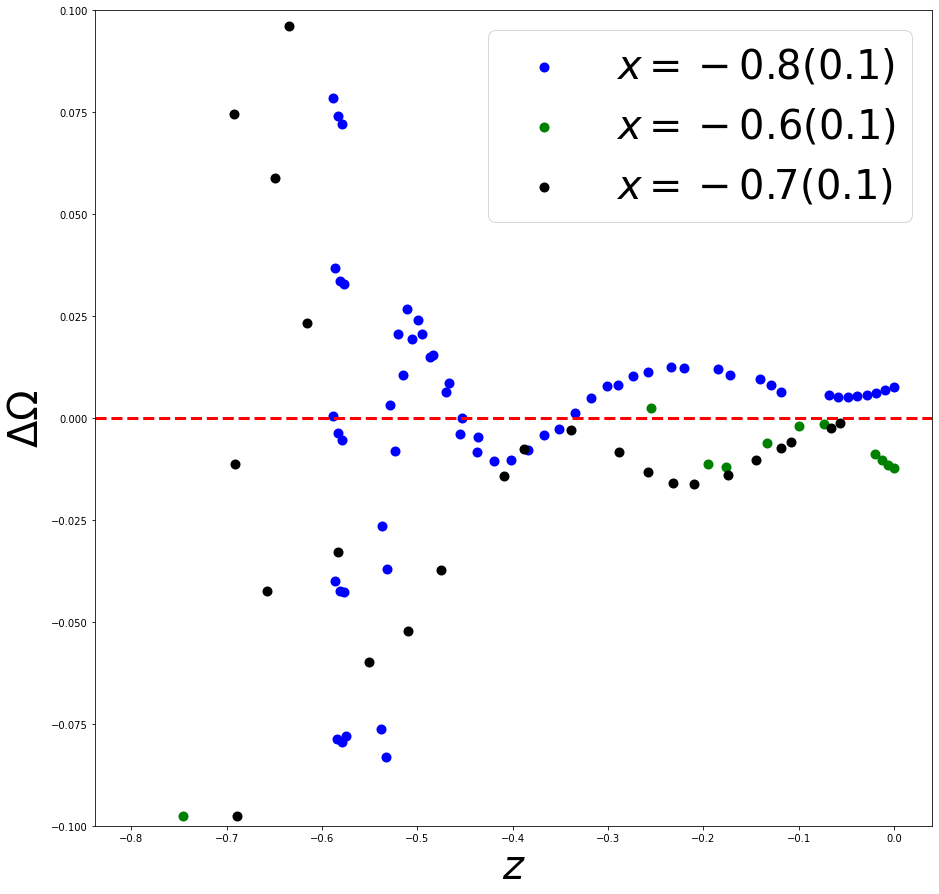

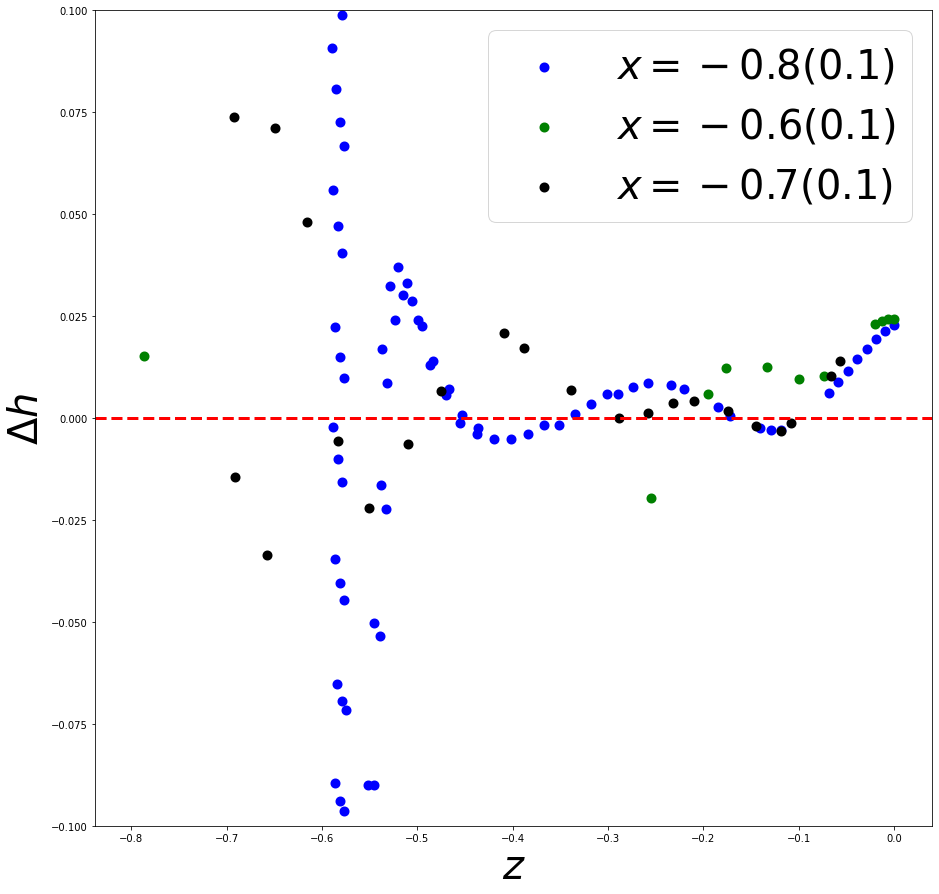

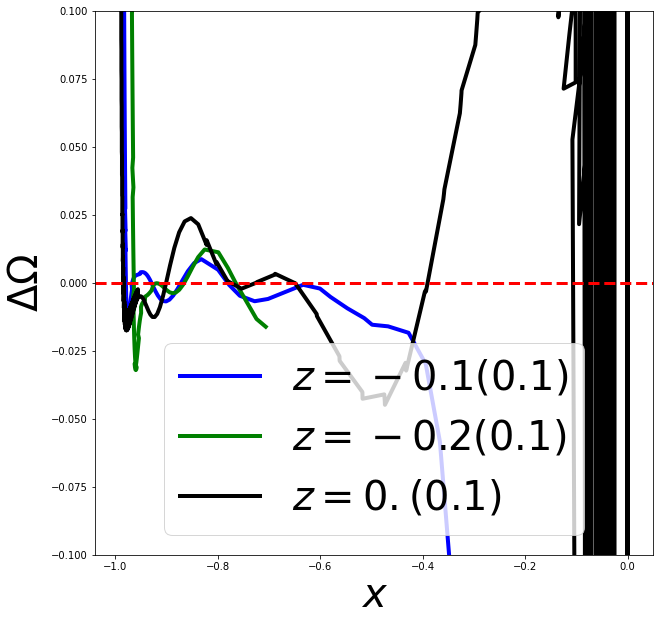

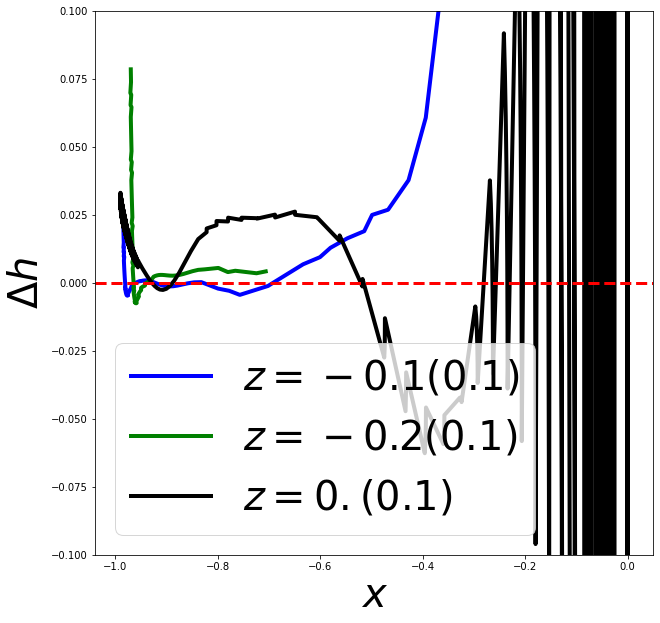

In [39]:



delta_omega=omega_dl.mean(-1).detach().numpy()+np.average(h_torch.detach().numpy()[:,1],axis=-1)
delta_h=h_dl.mean(-1).detach().numpy()+np.average(h_torch.detach().numpy()[:,0],axis=-1)
x_vector=np.average(x,axis=-1)
z_vector=np.average(z,axis=-1)

#%% Delta omega vs x and z
plt.figure(figsize=(15,15))

list_input=[]
list_output=[]
for i,r in enumerate(x_vector):
    if r < -0.8 and r > -0.81:
        list_input.append(z_vector[i])
        list_output.append(delta_omega[i])
plt.scatter(list_input,list_output,color='blue',linewidth=4,label=r'$x=-0.8(0.1)$')
list_input=[]
list_output=[]
for i,r in enumerate(x_vector):
    if r < -0.6 and r > -0.61:
        list_input.append(z_vector[i])
        list_output.append(delta_omega[i])
plt.scatter(list_input,list_output,color='green',linewidth=4,label=r'$x=-0.6(0.1)$')

list_input=[]
list_output=[]
for i,r in enumerate(x_vector):
    if r < -0.7 and r > -0.71:
        list_input.append(z_vector[i])
        list_output.append(delta_omega[i])
plt.scatter(list_input,list_output,color='black',linewidth=4,label=r'$x=-0.7(0.1)$')

plt.legend(fontsize=40)
plt.axhline(y=0.,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$z$',fontsize=40)
plt.ylabel(r'$\Delta \Omega$',fontsize=40)
plt.ylim([-0.1,0.1])
plt.show() 


#%% Delta h vs x and z
plt.figure(figsize=(15,15))

list_input=[]
list_output=[]
for i,r in enumerate(x_vector):
    if r < -0.8 and r > -0.81:
        list_input.append(z_vector[i])
        list_output.append(delta_h[i])
plt.scatter(list_input,list_output,color='blue',linewidth=4,label=r'$x=-0.8(0.1)$')
list_input=[]
list_output=[]
for i,r in enumerate(x_vector):
    if r < -0.6 and r > -0.61:
        list_input.append(z_vector[i])
        list_output.append(delta_h[i])
plt.scatter(list_input,list_output,color='green',linewidth=4,label=r'$x=-0.6(0.1)$')

list_input=[]
list_output=[]
for i,r in enumerate(x_vector):
    if r < -0.7 and r > -0.71:
        list_input.append(z_vector[i])
        list_output.append(delta_h[i])
plt.scatter(list_input,list_output,color='black',linewidth=4,label=r'$x=-0.7(0.1)$')

plt.legend(fontsize=40)
plt.axhline(y=0.,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$z$',fontsize=40)
plt.ylabel(r'$\Delta h$',fontsize=40)
plt.ylim([-0.1,0.1])
plt.show()


# Delta omega vs x at different Z
plt.figure(figsize=(10,10))
list_input=[]
list_output=[]
for i,r in enumerate(z_vector):
    if r < -0.1 and r > -0.11:
        list_input.append(x_vector[i])
        list_output.append(delta_omega[i])
plt.plot(list_input,list_output,color='blue',linewidth=4,label=r'$z=-0.1(0.1)$')
list_input=[]
list_output=[]
for i,r in enumerate(z_vector):
    if r < -0.2 and r > -0.21:
        list_input.append(x_vector[i])
        list_output.append(delta_omega[i])
plt.plot(list_input,list_output,color='green',linewidth=4,label=r'$z=-0.2(0.1)$')

list_input=[]
list_output=[]
for i,r in enumerate(z_vector):
    if r < 0.01 and r > -0.01:
        list_input.append(x_vector[i])
        list_output.append(delta_omega[i])
plt.plot(list_input,list_output,color='black',linewidth=4,label=r'$z=0.(0.1)$')

plt.legend(fontsize=40)
plt.axhline(y=0.,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$x$',fontsize=40)
plt.ylabel(r'$\Delta \Omega$',fontsize=40)
plt.ylim([-0.1,0.1])
plt.show() 


# Delta h vs x at different Z
plt.figure(figsize=(10,10))
list_input=[]
list_output=[]
for i,r in enumerate(z_vector):
    if r < -0.1 and r > -0.11:
        list_input.append(x_vector[i])
        list_output.append(delta_h[i])
plt.plot(list_input,list_output,color='blue',linewidth=4,label=r'$z=-0.1(0.1)$')
list_input=[]
list_output=[]
for i,r in enumerate(z_vector):
    if r < -0.2 and r > -0.21:
        list_input.append(x_vector[i])
        list_output.append(delta_h[i])
plt.plot(list_input,list_output,color='green',linewidth=4,label=r'$z=-0.2(0.1)$')

list_input=[]
list_output=[]
for i,r in enumerate(z_vector):
    if r < 0.01 and r > -0.01:
        list_input.append(x_vector[i])
        list_output.append(delta_h[i])
plt.plot(list_input,list_output,color='black',linewidth=4,label=r'$z=0.(0.1)$')

plt.legend(fontsize=40)
plt.axhline(y=0.,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$x$',fontsize=40)
plt.ylabel(r'$\Delta h$',fontsize=40)
plt.ylim([-0.1,0.1])
plt.show() 


Functional estimation or accuracy

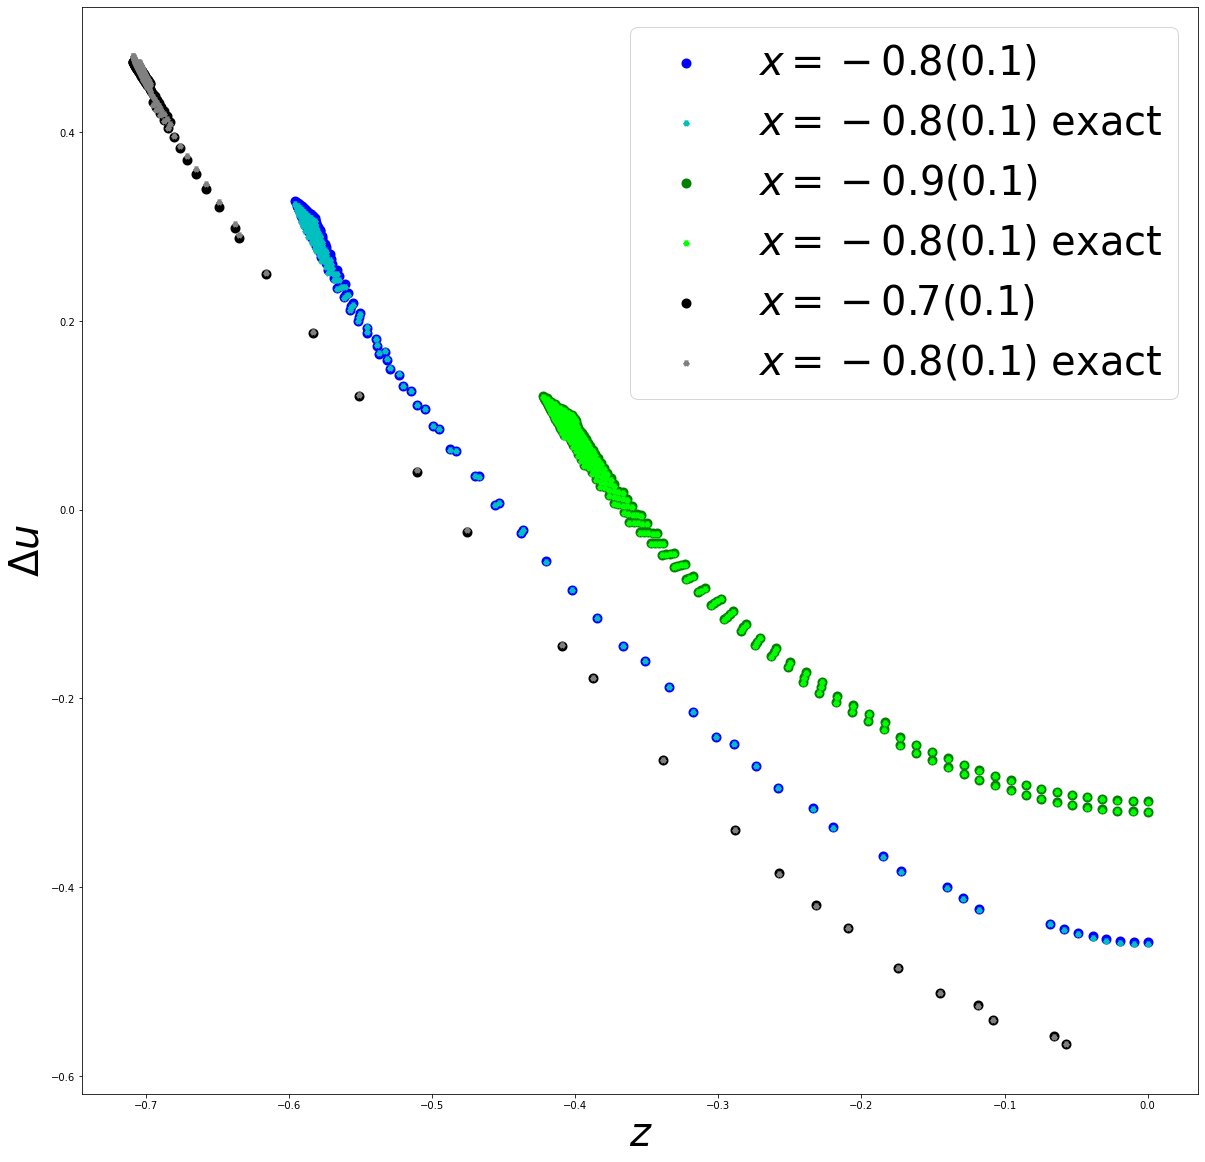

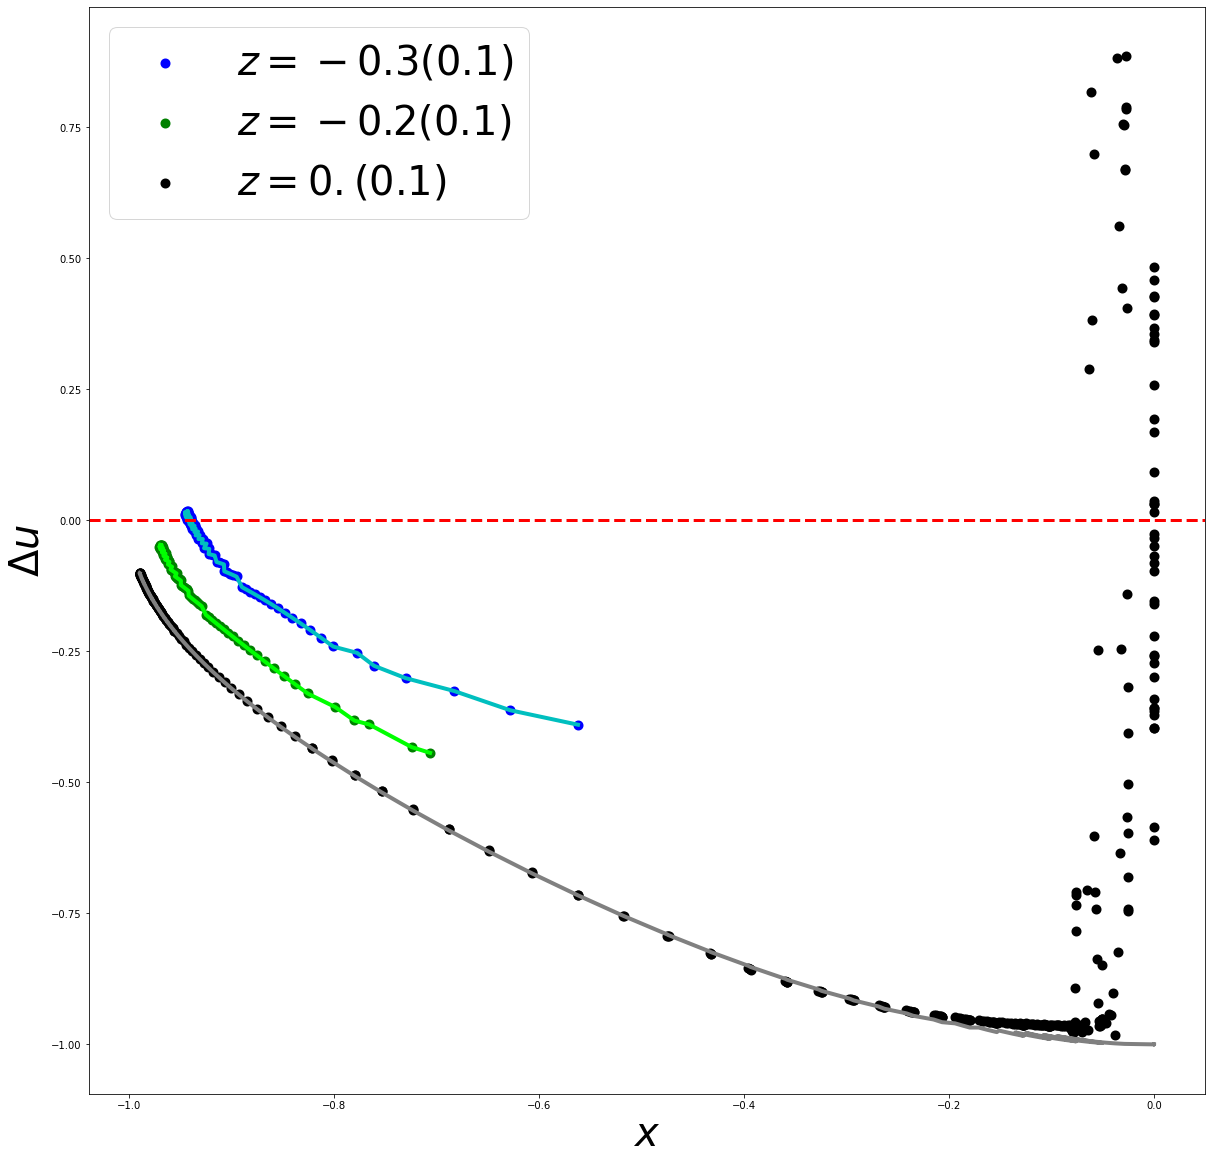

In [55]:
#%% Delta u vs x and z
f=f.reshape(-1)
plt.figure(figsize=(20,20))
du=f-f_value_dl
list_input=[]
list_output=[]
list_output_exact=[]
for i,r in enumerate(x_vector):
    if r < -0.8 and r > -0.81:
        list_input.append(z_vector[i])
        list_output.append(f_value_dl[i])
        list_output_exact.append(f[i])
plt.scatter(list_input,list_output,color='blue',linewidth=4,label=r'$x=-0.8(0.1)$')
plt.scatter(list_input,list_output_exact,color='c',linewidth=4,label=r'$x=-0.8(0.1)$ exact',marker='2',s=40)
list_input=[]
list_output=[]
list_output_exact=[]
for i,r in enumerate(x_vector):
    if r < -0.9 and r > -0.91:
        list_input.append(z_vector[i])
        list_output.append(f_value_dl[i])
        list_output_exact.append(f[i])
plt.scatter(list_input,list_output,color='green',linewidth=4,label=r'$x=-0.9(0.1)$')
plt.scatter(list_input,list_output_exact,color='lime',linewidth=4,label=r'$x=-0.8(0.1)$ exact',marker='2',s=40)
list_input=[]
list_output=[]
list_output_exact=[]
for i,r in enumerate(x_vector):
    if r < -0.7 and r > -0.71:
        list_input.append(z_vector[i])
        list_output.append(f_value_dl[i])
        list_output_exact.append(f[i])
        
plt.scatter(list_input,list_output,color='black',linewidth=4,label=r'$x=-0.7(0.1)$')        
plt.scatter(list_input,list_output_exact,color='grey',linewidth=4,label=r'$x=-0.8(0.1)$ exact',marker='2',s=40)


plt.legend(fontsize=40)
#plt.axhline(y=0.,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$z$',fontsize=40)
plt.ylabel(r'$\Delta u$',fontsize=40)
#plt.ylim([-0.005,0.005])
plt.show()





# Delta omega vs x at different Z
plt.figure(figsize=(20,20))
list_input=[]
list_output=[]
list_output_exact=[]
for i,r in enumerate(z_vector):
    if r < -0.3 and r > -0.31:
        list_input.append(x_vector[i])
        list_output.append(f_value_dl[i])
        list_output_exact.append(f[i])
plt.scatter(list_input,list_output,color='blue',linewidth=4,label=r'$z=-0.3(0.1)$')
plt.plot(list_input,list_output_exact,color='c',linewidth=4)
list_input=[]
list_output=[]
list_output_exact=[]
for i,r in enumerate(z_vector):
    if r < -0.2 and r > -0.21:
        list_input.append(x_vector[i])
        list_output.append(f_value_dl[i])
        list_output_exact.append(f[i])
plt.scatter(list_input,list_output,color='green',linewidth=4,label=r'$z=-0.2(0.1)$')
plt.plot(list_input,list_output_exact,color='lime',linewidth=4)

list_input=[]
list_output=[]
list_output_exact=[]
for i,r in enumerate(z_vector):
    if r < 0.01 and r > -0.01:
        list_input.append(x_vector[i])
        list_output.append(f_value_dl[i])
        list_output_exact.append(f[i])
plt.scatter(list_input,list_output,color='black',linewidth=4,label=r'$z=0.(0.1)$')
plt.plot(list_input,list_output_exact,color='grey',linewidth=4)
plt.legend(fontsize=40)
plt.axhline(y=0.,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$x$',fontsize=40)
plt.ylabel(r'$\Delta u$',fontsize=40)
#plt.ylim([-0.005,0.005])
plt.show() 




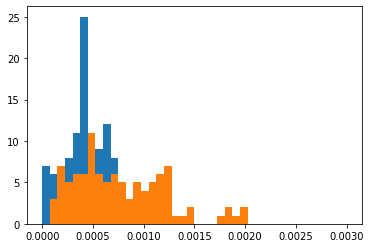

In [9]:
df_lda=np.average(np.abs(f_test-f_lda),axis=-1)
df_dl=np.average(np.abs(f_test-f_dl),axis=-1)

plt.hist(df_lda,bins=40,range=(0,0.003))
plt.hist(df_dl,bins=40,range=(0,0.003))
plt.show()

(100, 100)
(10000, 8)


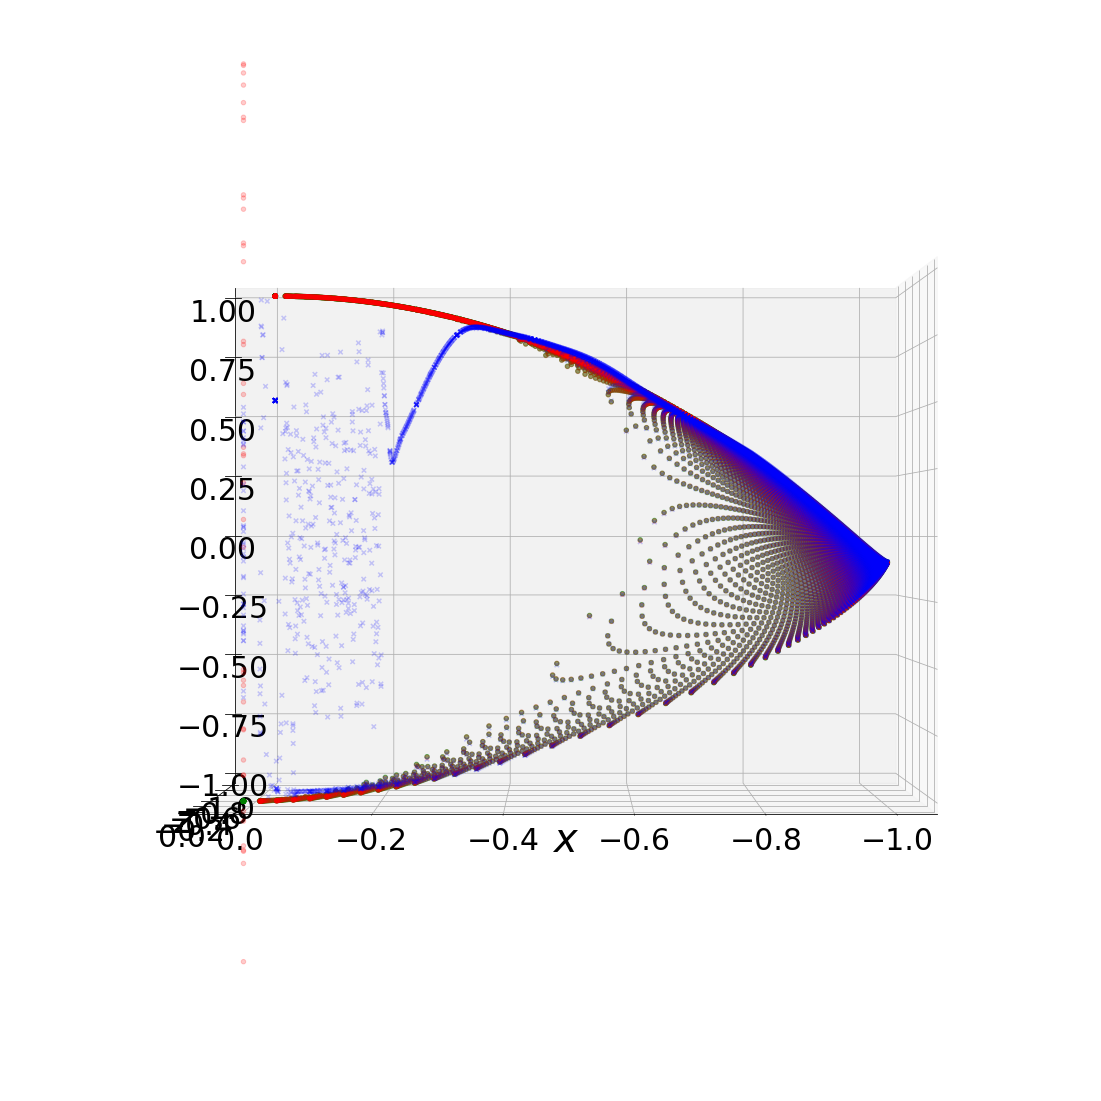

In [30]:
f_value_ml=np.average(f_ml,axis=-1).reshape(100,100)
f=f.reshape(100,100)
print(f.shape)
print(z.shape)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(20,20))
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),f,marker='o',color='green',alpha=0.5)
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),f_value_ml,marker='o',color='red',alpha=0.2)
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),f_value_dl,marker='x',color='blue',alpha=0.2)
plt.ylabel(r'$z$',fontsize=40)
plt.xlabel(r'$x$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
ax.view_init(elev=0, azim=90)
ax.set_zlim([-1,1])
plt.show()


Mapping of the errors

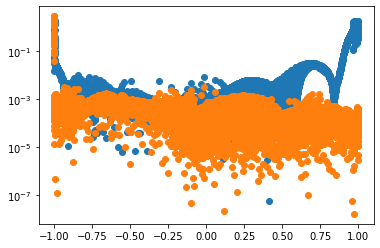

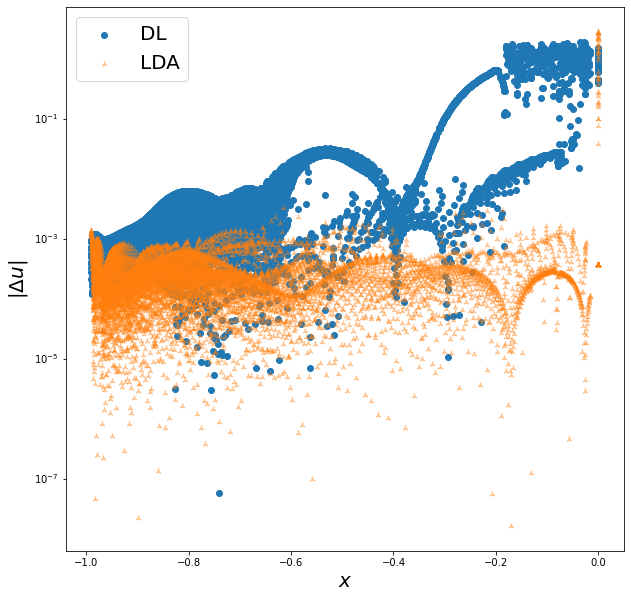

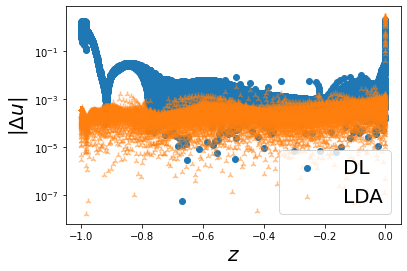

In [35]:
df_dl=np.abs(f.reshape(-1)-f_value_dl.reshape(-1))
df_lda=np.abs(f.reshape(-1)-f_value_ml.reshape(-1))

plt.scatter(f.reshape(-1),df_dl)
plt.scatter(f.reshape(-1),df_lda)
plt.semilogy()
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(np.average(x,axis=-1),df_dl,label=r'DL')
plt.scatter(np.average(x,axis=-1),df_lda,marker='2',alpha=0.5,label='LDA')
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$|\Delta u|$',fontsize=20)
plt.legend(fontsize=20)
plt.semilogy()
plt.show()


plt.scatter(np.average(z,axis=-1),df_dl,label=r'DL')
plt.scatter(np.average(z,axis=-1),df_lda,marker='2',alpha=0.5,label=r'LDA')
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$|\Delta u|$',fontsize=20)
plt.legend(fontsize=20)

plt.semilogy()
plt.show()


### LDA of the External fields

Imports

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import curve_fit

# def pade(z:np.ndarray,a_p,b_p,c_p,d_p,e_p,a_q,b_q,c_q,d_q):
#     z_poly=z[None,:]**((4-np.arange(5)))[:,None]
#     f=(z_poly[0,:]*a_p+z_poly[1,:]*b_p+z_poly[2,:]*c_p+z_poly[3,:]*d_p+z_poly[-1,:]*e_p)/(z_poly[0,:]*a_q+z_poly[1,:]*b_q+z_poly[2,:]*c_q+z_poly[3,:]*d_q)
#     return f

def pade(m:np.ndarray,*params):
    z=m[:,0]
    x=m[:,1]    
    
    z_poly=(z[None,:])**((np.arange(0,5,1)))[:,None]
    x_poly=(x[None,:])**((np.arange(0,5,1)))[:,None]
    up=np.zeros(m.shape[0])
    for i in range(5):
        for j in range(5):
            up=up+params[5*i+j]*z_poly[i,:]*x_poly[j,:]
    down=np.ones(m.shape[0])
    for i in range(4):
        for j in range(4):
            down=down+params[25+4*i+j]*z_poly[i,:]*x_poly[j,:]
            
    
    f=up/down
    return f

def lda_functional(m:np.ndarray,params):
    f_lda=np.zeros_like(m[:,0,:])
    for a in range(m.shape[-1]):
        z=m[:,0,a]
        x=m[:,1,a]    
        
        z_poly=(z[None,:])**((np.arange(0,5,1)))[:,None]
        x_poly=(x[None,:])**((np.arange(0,5,1)))[:,None]
        up=np.zeros(m.shape[0])
        for i in range(5):
            for j in range(5):
                up=up+params[5*i+j]*z_poly[i,:]*x_poly[j,:]
        down=np.ones(m.shape[0])
        for i in range(4):
            for j in range(4):
                down=down+params[25+4*i+j]*z_poly[i,:]*x_poly[j,:]
        f_lda[:,a]=up/down
    return f_lda

Data

0.5050505050505051 0.5050505050505051



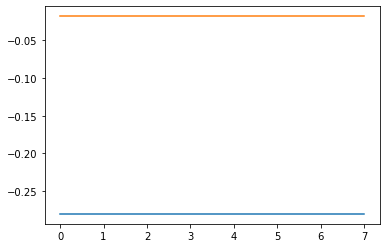

In [78]:
data=np.load('data/kohm_sham_approach/uniform/dataset_lda_h_0_5_omega_0_5_j_1_1nn_linear_span_100.npz')

z=data['density']
x=data['transverse_magnetization']

z_torch=torch.from_numpy(z)
x_torch=torch.from_numpy(x)



f_dens=data['density_F']
omega_value=data['omega_value']
h_value=data['h_value']

m_torch=torch.cat((z_torch.unsqueeze(1),x_torch.unsqueeze(1)),dim=1)
h_torch=torch.zeros_like(m_torch)
for i in range(100):
    for j in range(100):
        h_torch[i*100+j,0]=h_value[j]
        h_torch[i*100+j,1]=omega_value[i]

f=np.average(f_dens,axis=-1)
# # plt.hist(np.average(x,axis=-1),bins=100)
# # plt.show()
# # plt.hist(np.average(z,axis=-1),bins=100)
# # plt.show()
# # plt.hist(f,bins=100)
# # plt.show()
idx=10
jdx=10
print(omega_value[idx],h_value[jdx])

plt.plot(x[idx*100+jdx])
plt.plot(z[idx*100+jdx])
print()
plt.show()



Fit

In [90]:
from src.tddft_methods.model_lda import modelLDA
import torch

m=np.append(z.reshape(-1,1,8),x.reshape(-1,1,8),axis=1)

print(h_torch.shape)
params_z,_=curve_fit(f=pade,xdata=np.average(m,axis=-1),ydata=h_torch[:,1].mean(-1).detach().numpy(),p0=0.1*np.ones(25+16))


#model=modelLDA(torch.tensor(coeff))
h_ml=lda_functional(m=m,params=params_z)


torch.Size([10000, 2, 8])


Check Results

(10000, 8)


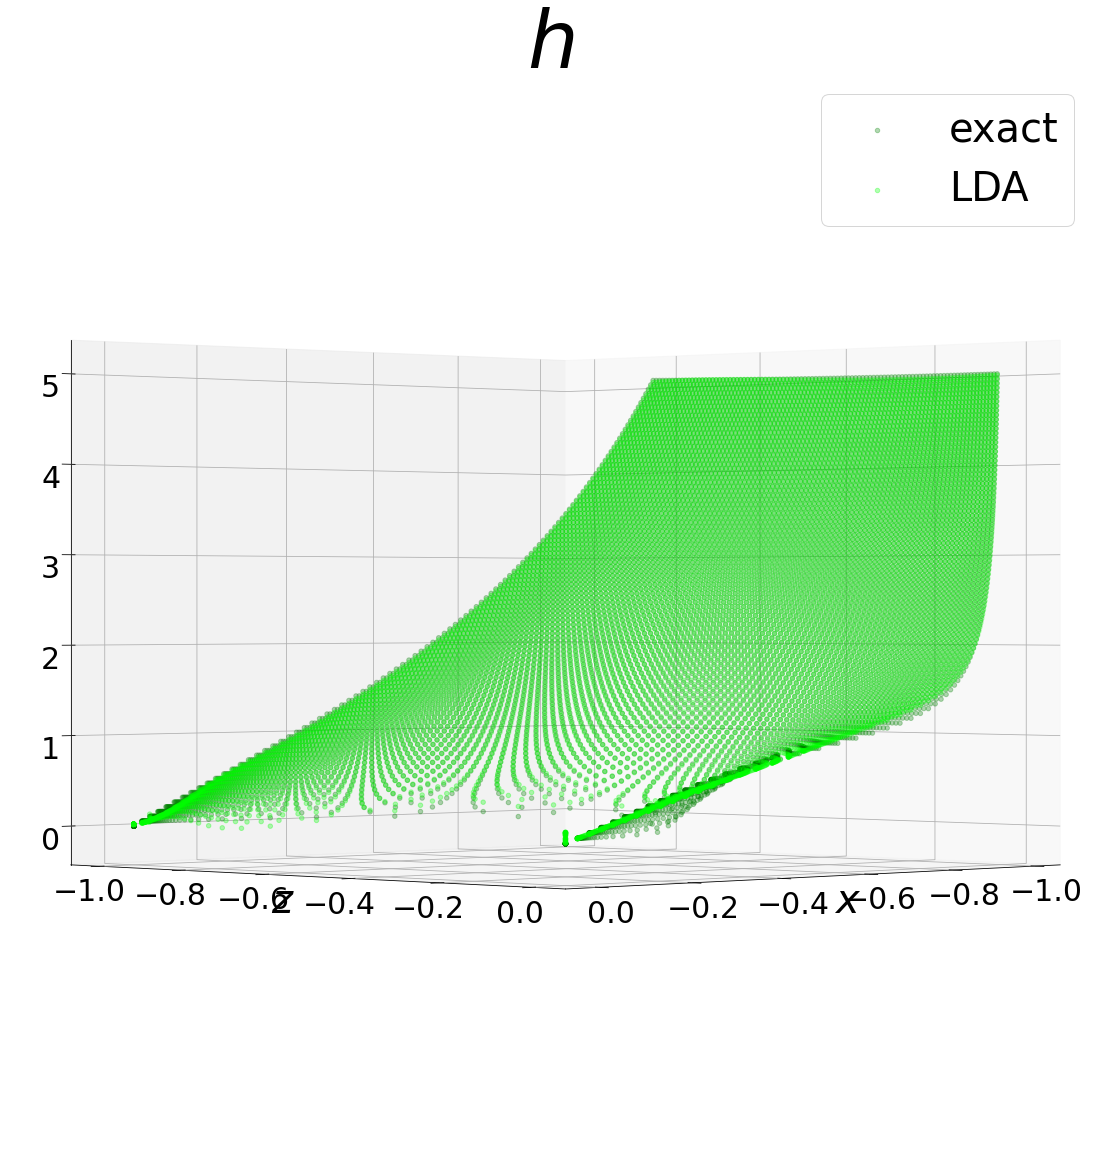

(10000,)


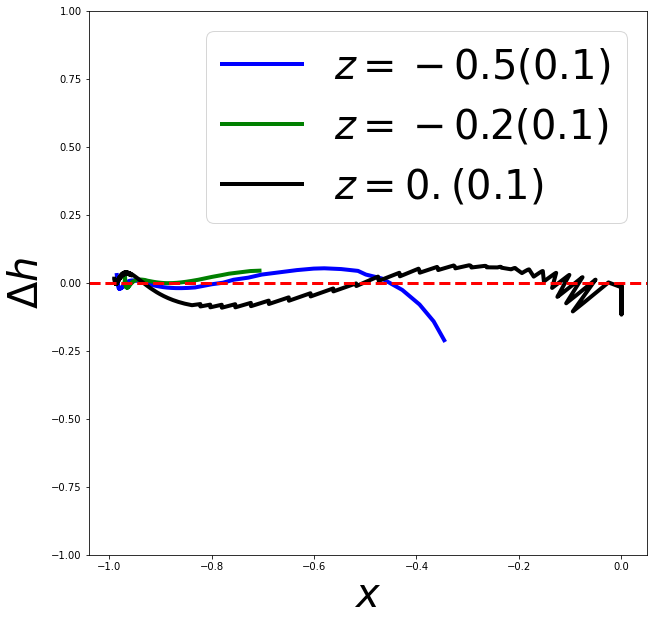

In [92]:
print(h_ml.shape)
h_value_ml=np.average(h_ml,axis=-1)

hs=np.zeros_like(f.reshape(-1))
for j in range(100):
    for i in range(100):
        hs[i+j*100]=h_value[i]
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(20,20))
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),omegas,marker='o',color='green',alpha=0.3,label='exact')
ax.scatter(np.average(x,axis=-1),np.average(z,axis=-1),h_value_ml,marker='o',color='lime',alpha=0.3,label='LDA')
plt.title(r'$h$',fontsize=80)
plt.ylabel(r'$z$',fontsize=40)
plt.xlabel(r'$x$',fontsize=40)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=2,
        )
plt.legend(fontsize=40)
ax.view_init(elev=0, azim=45)
#ax.set_zlim([-1,1])
#ax.set_ylim([-1,0])
#ax.set_xlim([-0.9001,-0.9])
plt.show()

print(hs.shape)
delta_h=omegas-h_value_ml
plt.figure(figsize=(10,10))
list_input=[]
list_output=[]
for i,r in enumerate(z_vector):
    if r < -0.1 and r > -0.11:
        list_input.append(x_vector[i])
        list_output.append(delta_h[i])
plt.plot(list_input,list_output,color='blue',linewidth=4,label=r'$z=-0.5(0.1)$')
list_input=[]
list_output=[]
for i,r in enumerate(z_vector):
    if r < -0.2 and r > -0.21:
        list_input.append(x_vector[i])
        list_output.append(delta_h[i])
plt.plot(list_input,list_output,color='green',linewidth=4,label=r'$z=-0.2(0.1)$')

list_input=[]
list_output=[]
for i,r in enumerate(z_vector):
    if r < 0.01 and r > -0.01:
        list_input.append(x_vector[i])
        list_output.append(delta_h[i])
plt.plot(list_input,list_output,color='black',linewidth=4,label=r'$z=0.(0.1)$')

plt.legend(fontsize=40)
plt.axhline(y=0.,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$x$',fontsize=40)
plt.ylabel(r'$\Delta h$',fontsize=40)
plt.ylim([-1,1])
plt.show() 